In [1]:
#Import require packages and libraries
! pip install -U imbalanced-learn
! pip install prettytable 
! pip install xgboost
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import std
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report,roc_auc_score,roc_curve, plot_confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from prettytable import PrettyTable
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import time
import statistics
from collections import Counter
from imblearn.over_sampling import SMOTENC

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.7/site-packages (0.8.1)


**Import Dataset**

In [2]:
df =pd.read_csv ('/home/jovyan/Onlineshoppersdata(1).csv')

# <font color='red'>**Classification Algortihms with Balanced dataset after applying random oversampling**</font>

> ### **Separate the data into Train and Test**

In [3]:
# split imbalanced dataset into train and test sets with stratification

X = df.drop(['Revenue'],axis=1).values   
y = df['Revenue'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 8338, 1: 1526})
Counter({0: 2084, 1: 382})


### **Using SMOTE to do a random oversampling of the minority instances from the Class label, we use SMOTE-NC when we have cases of mixed data. The premise is simple, we denote which features are categorical, and SMOTE would resample the categorical data instead of creating synthetic data.**

In [4]:
#Create an oversampled training data smote = SMOTENC([10,11,12,13,14,15,16]) #index for categorical variables
smote = SMOTENC([10,11,12,13,14,15,16],random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# convert to DMatrix
dtrain = xgb.DMatrix(X_train_sm, y_train_sm)
dtest = xgb.DMatrix(X_test, y_test)
print( 'The oversampled train set has icrease from '+ str(len(X_train)) + ' to '+ str(len(X_train_sm)) + ' instances')

The oversampled train set has icrease from 9864 to 16676 instances


Text(0.5, 1.0, 'Distribution of Class "Revenue" before applying oversample')

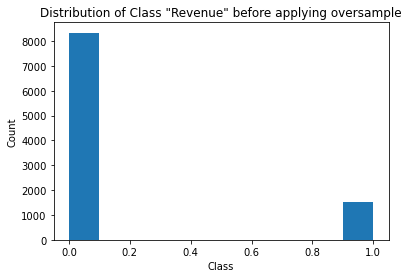

In [5]:
hist1= plt.hist(y_train)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Class "Revenue" before applying oversample')
#Plot that shows data distribution of the class label before applying oversampling

Text(0.5, 1.0, 'Distribution of Class "Revenue" after applying oversample')

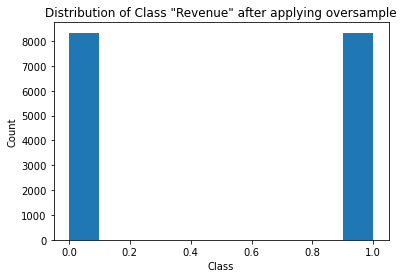

In [6]:
hist2=plt.hist(y_train_sm)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Class "Revenue" after applying oversample')
#Plot that shows data distribution of the class label after applying oversampling

## **Random Forest with K-Fold Cross Validation - Balanced Class Label**


> **Random Forest is a tree-based model and hence does not require feature scaling.**

Fold  1 
 Confusion matrix:  



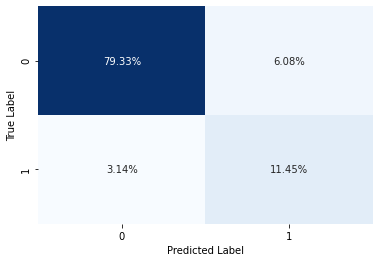

Fold  2 
 Confusion matrix:  



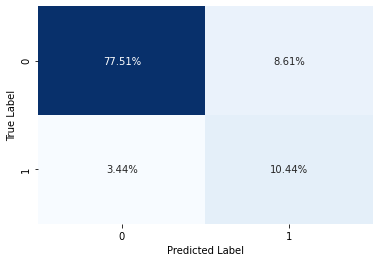

Fold  3 
 Confusion matrix:  



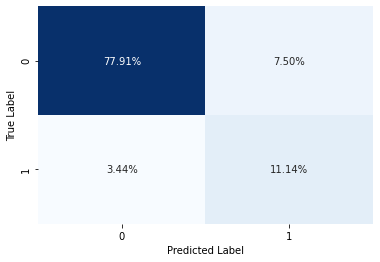

Fold  4 
 Confusion matrix:  



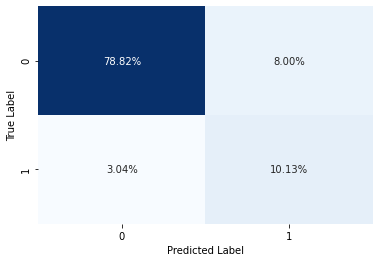

Fold  5 
 Confusion matrix:  



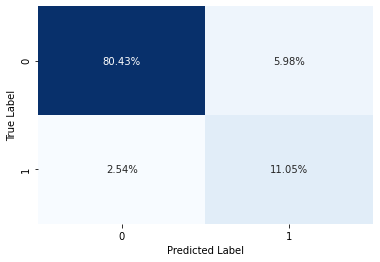

Fold  6 
 Confusion matrix:  



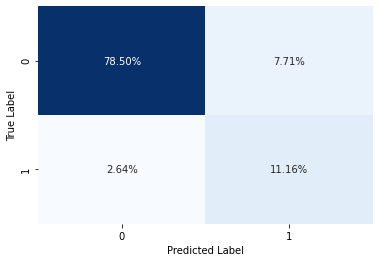

Fold  7 
 Confusion matrix:  



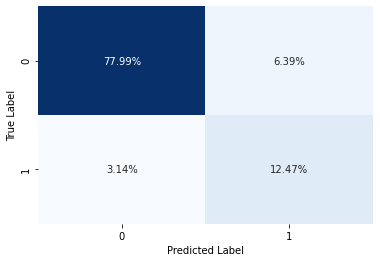

Fold  8 
 Confusion matrix:  



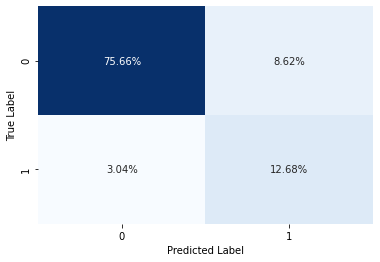

Fold  9 
 Confusion matrix:  



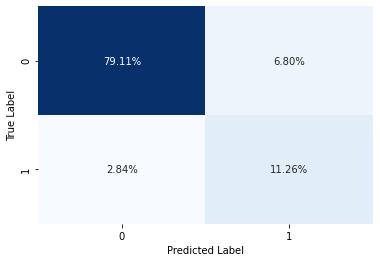

Fold  10 
 Confusion matrix:  



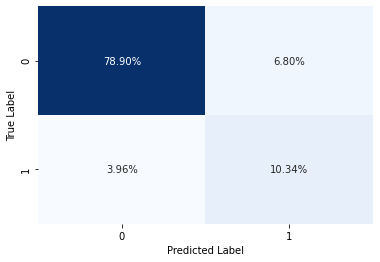

In [7]:
start_time = time.time()
#lists to append scores and get the average
accuracies = [] 
recalls=[]
precisions=[]
f1score=[]
matt1=[]
spe_rf=[]

forest= RandomForestClassifier(random_state=42)

kf = KFold(n_splits=10,random_state=42,shuffle=True) #use of Kfold cross validation to train the model using the Train set
kf.get_n_splits(X)
i=1

for train_index, test_index in kf.split(X_train, y_train):
    X_train_rf, X_test_rf = X[train_index], X[test_index]
    y_train_rf, y_test_rf = y[train_index], y[test_index]
    X_train_sm_rf, y_train_sm_rf = smote.fit_resample(X_train_rf, y_train_rf)  #apply smote to each train set within each fold  
    
    forest.fit(X_train_sm_rf, y_train_sm_rf)  
    y_pred_fk = forest.predict(X_test_rf)
    
    accuracy = accuracy_score(y_test_rf,y_pred_fk)
    f1= f1_score(y_test_rf,y_pred_fk, average='micro')
    recall= recall_score(y_test_rf,y_pred_fk, average='micro')
    precision = precision_score(y_test_rf,y_pred_fk, average='micro')
    mcc=matthews_corrcoef(y_test_rf,y_pred_fk)
    
    accuracies.append(accuracy)
    f1score.append(f1)
    recalls.append(recall)
    precisions.append(precision)
    matt1.append(mcc)
    
    cf_matrix=confusion_matrix(y_test_rf, y_pred_fk,labels=forest.classes_)  #calculate confusion matrix
    specificity_rf = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[0][1]) #calculate specificity
    
    spe_rf.append(specificity_rf)
    print("Fold ", i,"\n", "Confusion matrix: ","\n")   
   
    heatmap = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label") 
    plt.ylabel("True Label")
    plt.show()
    
    i=i+1
    
time_forest=(time.time() - start_time)
time_forest=time_forest=("--- %s seconds ---" % (time_forest))
average_accuracy = round(np.mean(accuracies)*100,2)
average_f1 = round(np.mean(f1score)*100,2)
average_recall =round(np.mean(recalls)*100,2)
average_precision = round(np.mean(precisions)*100,2)
average_mcc = round(np.mean(matt1)*100,2)
average_specificity_rf=round(np.mean(spe_rf)*100,2)

In [8]:
print('No of Folds for Random Forest: '+str(i-1))
print('This is the average accuracy of all the folds uisng Random Forest ' + str(average_accuracy))
print('This is the average F1 Score of all the folds uisng Random Forest ' + str(average_f1))
print('This is the average Recall  of all the folds uisng Random Forest ' + str(average_recall))
print('This is the average Precision of all the folds uisng Random Forest ' + str(average_precision))
print('This is the average MCC of all the folds uisng Random Forest ' + str(average_mcc))
print('This is the average Specificity of all the folds ' + str(average_specificity_rf))

No of Folds for Random Forest: 10
This is the average accuracy of all the folds uisng Random Forest 89.63
This is the average F1 Score of all the folds uisng Random Forest 89.63
This is the average Recall  of all the folds uisng Random Forest 89.63
This is the average Precision of all the folds uisng Random Forest 89.63
This is the average MCC of all the folds uisng Random Forest 63.02
This is the average Specificity of all the folds 60.81


## **XGBoost Model With k-Fold Cross Validation**

 > **Data normalization is not necessary for decision trees. Since XGBoost is based on decision trees, is not necessary to do data normalization**

In [9]:
start_time = time.time()
params_1 = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.1,
    'objective': 'binary:hinge',
    'eval_metric':'logloss',
    'random_state':42
}

Fold  1 
 Confusion matrix:  



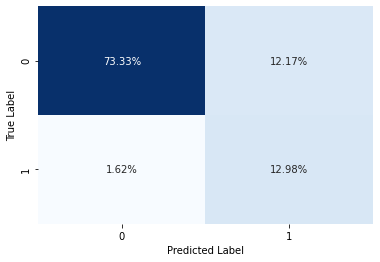

Fold  2 
 Confusion matrix:  



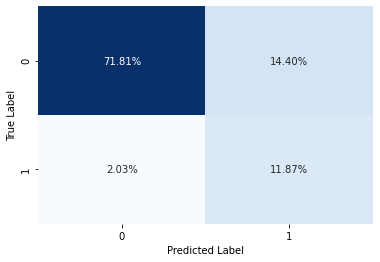

Fold  3 
 Confusion matrix:  



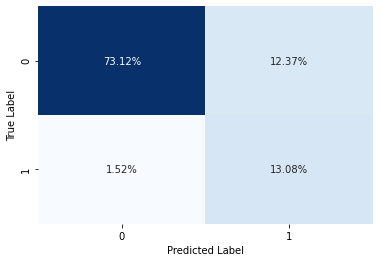

Fold  4 
 Confusion matrix:  



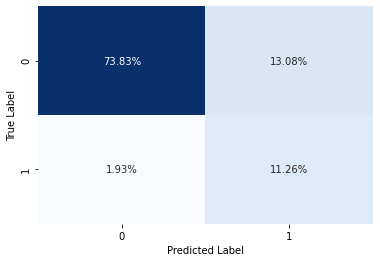

Fold  5 
 Confusion matrix:  



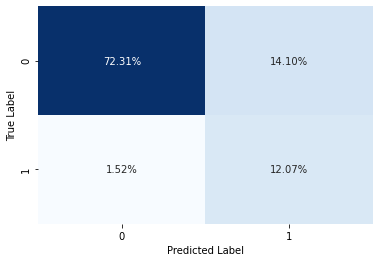

Fold  6 
 Confusion matrix:  



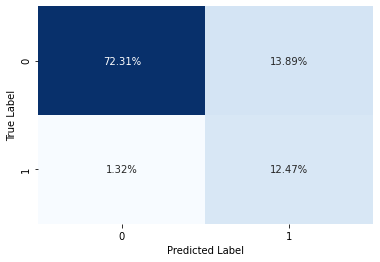

Fold  7 
 Confusion matrix:  



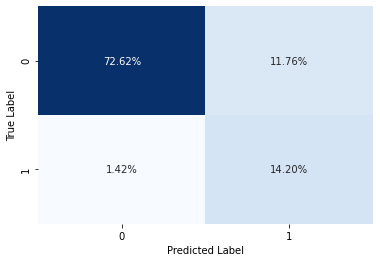

Fold  8 
 Confusion matrix:  



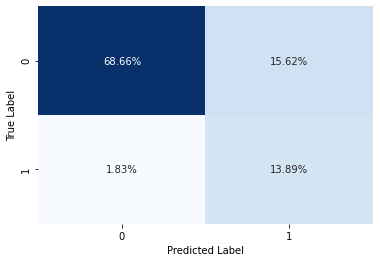

Fold  9 
 Confusion matrix:  



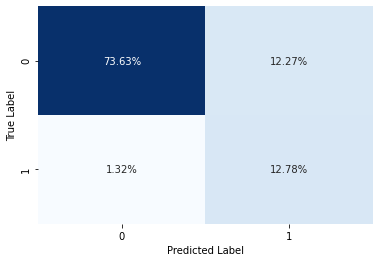

Fold  10 
 Confusion matrix:  



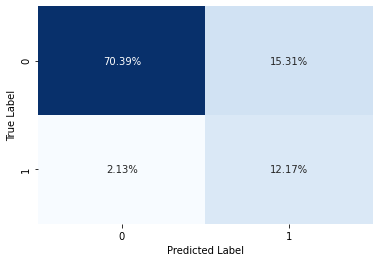

In [10]:
accuracies_xg = []
recalls_xg=[]
precisions_xg=[]
f1score_xg=[]
matt2=[]
spe_xg=[]

kf = KFold(n_splits=10,random_state=42,shuffle=True) #use of Kfold cross validation to train the model using the Train set

kf.get_n_splits(X)
i=1

for train_index, test_index in kf.split(X_train, y_train):
    X_train_xg, X_test_xg = X[train_index], X[test_index]
    y_train_xg, y_test_xg = y[train_index], y[test_index]
    X_train_sm_xg, y_train_sm_xg = smote.fit_resample(X_train_xg, y_train_xg)#apply smote to each train set within each fold
    
    # convert to DMatrix
    d_train = xgb.DMatrix(X_train_sm_xg, y_train_sm_xg)
    d_test = xgb.DMatrix(X_test_xg, y_test_xg)
    #DMatrix is an optimized data structure that provides better memory efficiency and training speed, is an internal data structure that helps with memory management and data optimization. 

    modelxg = xgb.train(params_1, d_train)
    y_pred_xg = modelxg.predict(d_test)

    accuracy_xg = accuracy_score(y_test_xg,y_pred_xg)
    f1_xg= f1_score(y_test_xg,y_pred_xg, average='micro')
    recall_xg= recall_score(y_test_xg,y_pred_xg, average='micro')
    precision_xg = precision_score(y_test_xg,y_pred_xg, average='micro')
    mcc_xg=matthews_corrcoef(y_test_xg,y_pred_xg)
      
    accuracies_xg.append(accuracy_xg)
    f1score_xg.append(f1_xg)
    recalls_xg.append(recall_xg)
    precisions_xg.append(precision_xg)
    matt2.append(mcc_xg)
    
    cf_matrix_xg=confusion_matrix(y_test_xg,y_pred_xg)#calculate confusion matrix
    specificity_xg = cf_matrix_xg[1][1]/(cf_matrix_xg[1][1]+cf_matrix_xg[0][1])#calculate specificity

    spe_xg.append(specificity_xg)
    
    print("Fold ", i,"\n", "Confusion matrix: ","\n")
    heatmap = sns.heatmap(cf_matrix_xg/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label") 
    plt.ylabel("True Label")
    plt.show()
    
    i=i+1
    
time_xg=(time.time() - start_time)
time_xg=time_xg=("--- %s seconds ---" % (time_xg))
average_accuracy_xg = round(np.mean(accuracies_xg)*100,2)
average_f1_xg = round(np.mean(f1score_xg)*100,2)
average_recall_xg =round(np.mean(recalls_xg)*100,2)
average_precision_xg = round(np.mean(precisions_xg)*100,2)
average_mcc_xg = round(np.mean(matt2)*100,2)
average_specificity_xg=round(np.mean(spe_xg)*100,2)

In [11]:
print('No of Folds for XGBoost: '+str(i-1))
print('This is the average accuracy of all the folds ' + str(average_accuracy_xg))
print('This is the average F1 Score of all the folds ' + str(average_f1_xg))
print('This is the average Recall  of all the folds ' + str(average_recall_xg))
print('This is the average Precision of all the folds ' + str(average_precision_xg))
print('This is the average MCC of all the folds ' + str(average_mcc_xg))
print('This is the average Specificity of all the folds ' + str(average_specificity_xg))

No of Folds for XGBoost: 10
This is the average accuracy of all the folds 84.84
This is the average F1 Score of all the folds 84.84
This is the average Recall  of all the folds 84.84
This is the average Precision of all the folds 84.84
This is the average MCC of all the folds 57.93
This is the average Specificity of all the folds 48.49


## **Naive Bayes With k-Fold Cross Validation**

>  **As Naive Bayes algorithm is based on probability not on distance, so it doesn't require feature scaling**


Fold  1 
 Confusion matrix:  



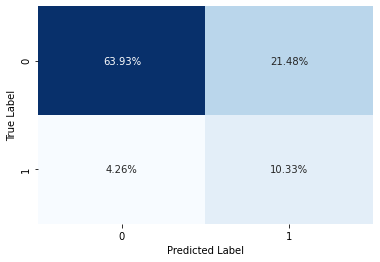

Fold  2 
 Confusion matrix:  



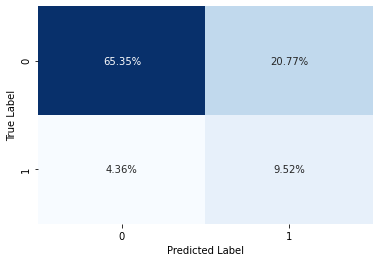

Fold  3 
 Confusion matrix:  



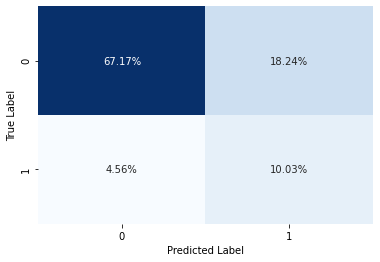

Fold  4 
 Confusion matrix:  



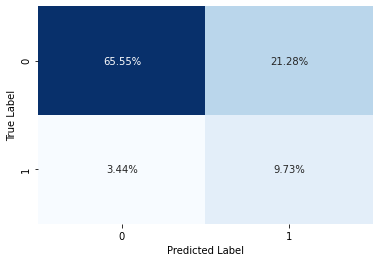

Fold  5 
 Confusion matrix:  



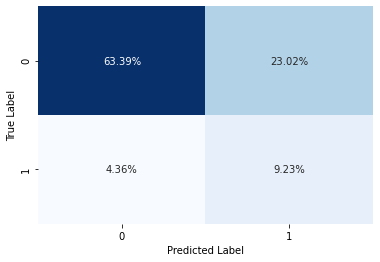

Fold  6 
 Confusion matrix:  



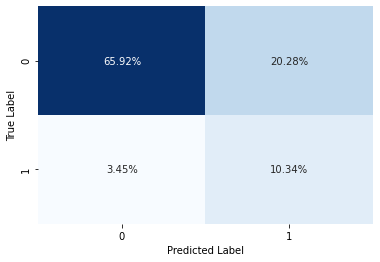

Fold  7 
 Confusion matrix:  



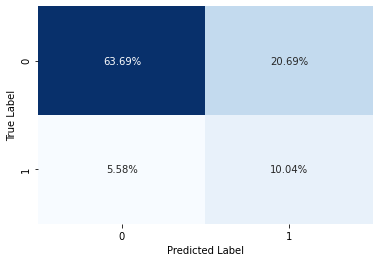

Fold  8 
 Confusion matrix:  



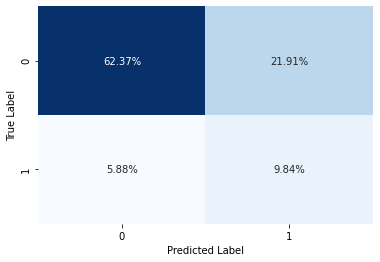

Fold  9 
 Confusion matrix:  



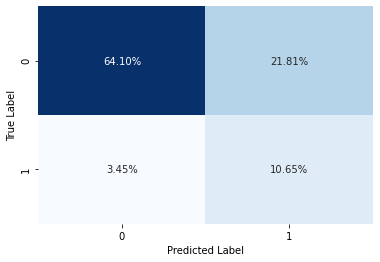

Fold  10 
 Confusion matrix:  



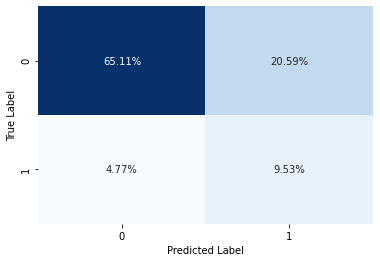

In [12]:
start_time = time.time()

model_nb = GaussianNB()

accuracies_nb = []
recalls_nb=[]
precisions_nb=[]
f1score_nb=[]
matt3=[]
spe_nb=[]

kf = KFold(n_splits=10,random_state=42,shuffle=True)#use of Kfold cross validation to train the model using the Train set
kf.get_n_splits(X)
i=1

for train_index, test_index in kf.split(X_train, y_train):  
    X_train_nb, X_test_nb = X[train_index], X[test_index]
    y_train_nb, y_test_nb = y[train_index], y[test_index]
    X_train_sm_nb, y_train_sm_nb = smote.fit_resample(X_train_nb, y_train_nb) #apply smote to each train set within each fold   
    
    model_nb.fit(X_train_sm_nb, y_train_sm_nb)  
    y_pred_nbk = model_nb.predict(X_test_nb)
    
    accuracy_nb = accuracy_score(y_test_nb,y_pred_nbk)
    f1_nb= f1_score(y_test_nb,y_pred_nbk, average='micro')
    recall_nb= recall_score(y_test_nb,y_pred_nbk, average='micro')
    precision_nb = precision_score(y_test_nb,y_pred_nbk, average='micro')
    mcc_nb=matthews_corrcoef(y_test_nb,y_pred_nbk)
      
    accuracies_nb.append(accuracy_nb)
    f1score_nb.append(f1_nb)
    recalls_nb.append(recall_nb)
    precisions_nb.append(precision_nb)
    matt3.append(mcc_nb)
    
    cf_matrix_nb=confusion_matrix(y_test_nb,y_pred_nbk,labels=model_nb.classes_)#calculate confusion matrix
    specificity_nb = cf_matrix_nb[1][1]/(cf_matrix_nb[1][1]+cf_matrix_nb[0][1])#calculate specificity

    spe_nb.append(specificity_nb)    
   
    print("Fold ", i,"\n", "Confusion matrix: ","\n")
    heatmap = sns.heatmap(cf_matrix_nb/np.sum(cf_matrix_nb), annot=True,fmt='.2%', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label") 
    plt.ylabel("True Label")
    plt.show()      
    
    i=i+1

time_nb=(time.time() - start_time)  
time_nb=("--- %s seconds ---" % (time_nb))
average_accuracy_nb = round(np.mean(accuracies_nb)*100,2)
average_f1_nb = round(np.mean(f1score_nb)*100,2)
average_recall_nb =round(np.mean(recalls_nb)*100,2)
average_precision_nb = round(np.mean(precisions_nb)*100,2)
average_mcc_nb = round(np.mean(matt3)*100,2)
average_specificity_nb=round(np.mean(spe_nb)*100,2)

In [13]:
print('No of Folds for Naive Bayes: '+str(i-1))
print('This is the average accuracy of all the folds ' + str(average_accuracy_nb))
print('This is the average F1 Score of all the folds ' + str(average_f1_nb))
print('This is the average Recall  of all the folds ' + str(average_recall_nb))
print('This is the average Precision of all the folds ' + str(average_precision_nb))
print('This is the average MCC of all the folds ' + str(average_mcc_nb))
print('This is the average Specificity of all the folds ' + str(average_specificity_nb))

No of Folds for Naive Bayes: 10
This is the average accuracy of all the folds 74.58
This is the average F1 Score of all the folds 74.58
This is the average Recall  of all the folds 74.58
This is the average Precision of all the folds 74.58
This is the average MCC of all the folds 33.98
This is the average Specificity of all the folds 32.13


> ## Test Set

<strong>**After we have trained the models with train data, we proceed to test the models with previously reserved Test data**</strong>

> 

In [14]:
preds_forest=forest.predict(X_test)
preds_xg = modelxg.predict(dtest)
pred_nb=model_nb.predict(X_test)

> **Metrics**

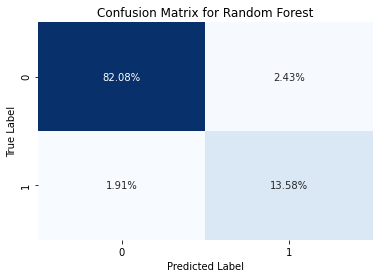

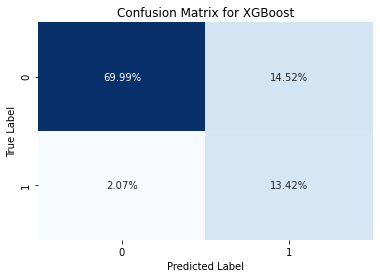

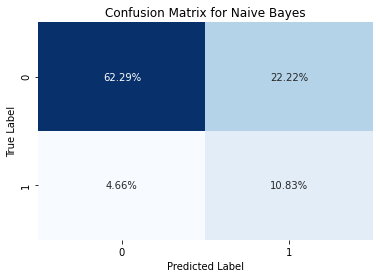

<Figure size 432x288 with 0 Axes>

In [15]:
accuracy_rf = round(accuracy_score(y_test, preds_forest)*100,2)
f1_rf= round(f1_score(y_test, preds_forest, average='weighted')*100,2) #Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label)
recall_rf= round(recall_score(y_test, preds_forest, average='weighted')*100,2)
precision_rf = round(precision_score(y_test, preds_forest, average='weighted')*100,2)
mcc_rf=round(matthews_corrcoef(y_test, preds_forest)*100,2)
matrix_forest=confusion_matrix(y_test, preds_forest,labels=forest.classes_)
specificity_forest = round(matrix_forest[1][1]/(matrix_forest[1][1]+matrix_forest[0][1])*100,2)
heatmap = sns.heatmap(matrix_forest/np.sum(matrix_forest), annot=True,fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label") 
plt.ylabel("True Label")
plt.title('Confusion Matrix for Random Forest')
plt.show()
plt.savefig('cf rf smote.png', dpi=300, bbox_inches='tight')

accuracy_xgb = round(accuracy_score(y_test, preds_xg)*100,2)
f1_xgb= round(f1_score(y_test, preds_xg, average='weighted')*100,2)
recall_xgb= round(recall_score(y_test, preds_xg, average='weighted')*100,2)
precision_xgb = round(precision_score(y_test, preds_xg, average='weighted')*100,2)
mcc_xgb=round(matthews_corrcoef(y_test, preds_xg)*100,2)
matrix_xgboost=confusion_matrix(y_test, preds_xg)   
specificity_xgb = round(matrix_xgboost[1][1]/(matrix_xgboost[1][1]+matrix_xgboost[0][1])*100,2)
heatmap = sns.heatmap(matrix_xgboost/np.sum(matrix_xgboost), annot=True,fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label") 
plt.ylabel("True Label")
plt.title('Confusion Matrix for XGBoost')
plt.show()
plt.savefig('cf XG smote.png', dpi=300, bbox_inches='tight')

accuracy_nvb = round(accuracy_score(y_test, pred_nb)*100,2)
f1_nvb= round(f1_score(y_test, pred_nb, average='weighted')*100,2)
recall_nvb= round(recall_score(y_test, pred_nb, average='weighted')*100,2)
precision_nvb = round(precision_score(y_test, pred_nb, average='weighted')*100,2)
mcc_nvb=round(matthews_corrcoef(y_test, pred_nb)*100,2)
matrix_nvb=confusion_matrix(y_test, pred_nb,labels=model_nb.classes_)   
specificity_nvb = round(matrix_nvb[1][1]/(matrix_nvb[1][1]+matrix_nvb[0][1])*100,2)
heatmap = sns.heatmap(matrix_nvb/np.sum(matrix_nvb), annot=True,fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label") 
plt.ylabel("True Label")
plt.title('Confusion Matrix for Naive Bayes')
plt.show()
plt.savefig('cf NB smote.png', dpi=300, bbox_inches='tight')

In [16]:
#Classification Report for each Model with test data
clsf_report_rf=classification_report(y_test, preds_forest)
print('Classification Report for Random Forest with Test data')
print(clsf_report_rf)

clsf_report_xg=classification_report(y_test, preds_xg)
print('Classification Report for XGBoost with Test data')
print(clsf_report_xg)

clsf_report_nb=classification_report(y_test, pred_nb)
print('Classification Report for Naive Bayes with Test data')
print(clsf_report_nb)

Classification Report for Random Forest with Test data
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2084
           1       0.85      0.88      0.86       382

    accuracy                           0.96      2466
   macro avg       0.91      0.92      0.92      2466
weighted avg       0.96      0.96      0.96      2466

Classification Report for XGBoost with Test data
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      2084
           1       0.48      0.87      0.62       382

    accuracy                           0.83      2466
   macro avg       0.73      0.85      0.76      2466
weighted avg       0.90      0.83      0.85      2466

Classification Report for Naive Bayes with Test data
              precision    recall  f1-score   support

           0       0.93      0.74      0.82      2084
           1       0.33      0.70      0.45       382

    accuracy             

In [17]:
# predict probabilities
pred_prob1 = forest.predict_proba(X_test)
pred_prob2 = model_nb.predict_proba(X_test)
pred_prob3= modelxg.predict(dtest)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3= roc_curve(y_test,pred_prob3,pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# auc scores
auc_score1 = round(roc_auc_score(y_test, pred_prob1[:,1],average='weighted')*100,2)
auc_score2 = round(roc_auc_score(y_test, pred_prob2[:,1],average='weighted')*100,2)
auc_score3 = round(roc_auc_score(y_test,preds_xg,average='weighted')*100,2)

> **Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.**

In [18]:
# Specify the Column Names while initializing the Table 
traintable= PrettyTable(["Metrics/Classifier", "Random Forest", "XGBoost", "Naive Bayes"]) 

# Add rows 
traintable.add_row(["Accuracy", average_accuracy, average_accuracy_xg, average_accuracy_nb]) 
traintable.add_row(["Precision", average_precision, average_precision_xg, average_precision_nb]) 
traintable.add_row(["Recall weighted", average_recall, average_recall_xg, average_recall_nb]) 
traintable.add_row(["F1 Score", average_f1, average_f1_xg, average_f1_nb])  
traintable.add_row(["MCC", average_mcc, average_mcc_xg, average_mcc_nb])
traintable.add_row(["Specificity", average_specificity_rf, average_specificity_xg, average_specificity_nb]) 
traintable.add_row(["Time", time_forest, time_xg, time_nb])

print('Comparisson of metrics with Training Set using Kfold cross Validation - Resampled Dataset')
print(traintable)


Comparisson of metrics with Training Set using Kfold cross Validation - Resampled Dataset
+--------------------+------------------------------------+------------------------------------+-----------------------------------+
| Metrics/Classifier |           Random Forest            |              XGBoost               |            Naive Bayes            |
+--------------------+------------------------------------+------------------------------------+-----------------------------------+
|      Accuracy      |               89.63                |               84.84                |               74.58               |
|     Precision      |               89.63                |               84.84                |               74.58               |
|  Recall weighted   |               89.63                |               84.84                |               74.58               |
|      F1 Score      |               89.63                |               84.84                |               7

In [19]:
testable = PrettyTable(["Metrics/Classifier", "Random Forest", "XGBoost", "Naive Bayes"]) 

# Add rows 
testable.add_row(["Accuracy", accuracy_rf, accuracy_xgb, accuracy_nvb]) 
testable.add_row(["Precision", precision_rf, precision_xgb, precision_nvb]) 
testable.add_row(["Recall weighted", recall_rf, recall_xgb, recall_nvb]) 
testable.add_row(["F1 Score", f1_rf, f1_xgb, f1_nvb]) 
testable.add_row(["AUC Score", auc_score1, auc_score2, auc_score3]) 
testable.add_row(["MCC", mcc_rf, mcc_xgb, mcc_nvb]) 
testable.add_row(["Specificity", specificity_forest, specificity_xgb, specificity_nvb]) 
testable.add_row(["Time for trainning", time_forest, time_xg, time_nb]) 


print('Comparisson of metrics with Test Set previously reserved - Resampled Dataset')
print(testable)

Comparisson of metrics with Test Set previously reserved - Resampled Dataset
+--------------------+------------------------------------+------------------------------------+-----------------------------------+
| Metrics/Classifier |           Random Forest            |              XGBoost               |            Naive Bayes            |
+--------------------+------------------------------------+------------------------------------+-----------------------------------+
|      Accuracy      |               95.66                |               83.41                |               73.11               |
|     Precision      |               95.73                |               89.53                |                83.7               |
|  Recall weighted   |               95.66                |               83.41                |               73.11               |
|      F1 Score      |               95.69                |               85.13                |               76.42         

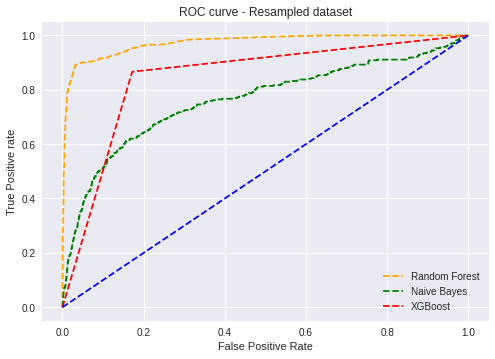

In [20]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Naive Bayes')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='XGBoost')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve - Resampled dataset')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('roc smote.png', dpi=300, bbox_inches='tight')
plt.show();

> **The best classifier has the largest area under the curve**